In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import emoji
from os.path import join
import json
import time

from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [2]:
# getting the twitter comments
DATA_PATH = join('..','data','twitter-data-cleaned.txt')
with open(DATA_PATH, 'r',  encoding="utf-8") as f:
    data = f.readlines()
data = [d.strip() for d in data if d.strip() != '']
print('Tweets')
print(data[:3])
print(len(data))

# getting our chosen emojis
SELECTED_EMOJIS_PATH = join('..','data','best-emojis.json')
with open(SELECTED_EMOJIS_PATH, 'r', encoding='utf-8') as f:
    EMOJIS = json.load(f)
EMOJI_CHARS = [e['char'] for e in EMOJIS]
print('Chosen emojis')
print(EMOJI_CHARS)
print(len(EMOJI_CHARS))

ALL_EMOJIS = set(emoji.emojize(emoji_code) for emoji_code in emoji.UNICODE_EMOJI.values())

Tweets
['💫 IT’S BURGER MONDAY, CBUS! 💫 Order any Gourmet Burger with a draft beer 🍔🍺 ifor just $9.99 when you dine in. 💪 Cer…', 'Stay strong 💪 You are an amazing man. I appreciate the truth that is told.', 'Code Sale Awesome from Styli 💪']
122179
Chosen emojis
['😂', '😍', '😭', '😊', '💕', '😒', '😉', '👌', '👍', '🙏', '👀', '🔥', '💯', '👏', '💪']
15


In [3]:
# preprocessing the data
from parsing import Tokenizer, TokenType, Token
tokenizer = Tokenizer(EMOJI_CHARS)
# take 3 previous words as context for the emoji
context = {e:[] for e in EMOJI_CHARS}
emojiToId = {e:i for i,e in enumerate(EMOJI_CHARS)}

for tweet in data:
    tokens = tokenizer.tokenize(tweet)
    for i,token in enumerate(tokens):
        if token.token_type == TokenType.EMOJIS:
            closest = tokenizer.findClosestNWords(5, tokens, i)
            if closest:
                context[token.raw].append(closest)

for e, words in context.items():
    print(e)
    print(len(words))
    print(words[:3])

😂
8458
[['familiar', 'with', 'my', 'face', 'too'], ['bollywood', 'reality'], ['though', 'your', 'debates', 'be', 'blasphemy']]
😍
7330
[['figura', 'is', 'a', 'start', 'today'], ['200', 'days', 'to', 'go'], ['200', 'days', 'to', 'go']]
😭
7464
[['lol', 'procrastination', 'almost', 'had', 'me'], ['just', 'change', 'my', 'first', 'diaper'], ['52', 'yuan', 'for', 'this', 'set']]
😊
6352
[['you', 'today', 'credit', 'stacie', 'swift'], ['fantastic', 'well', 'done', 'ladies'], ['congratulations', 'fam', 'all', 'the', 'best']]
💕
6485
[['happy', 'birthday', 'my', 'mochiiii', 'saranghae'], ['got', 'this', 'soon', 'youre', 'done'], ['we', 'got', 'this']]
😒
5873
[['️', 'dunk', 'it', 'ang', 'hina'], ['comes', '17', 'on', 'uber', 'eats'], ['comes', '17', 'on', 'uber', 'eats']]
😉
5932
[['start', 'today', 'choose', 'your', 'package'], ['the', 'richest', 'man', 'your', 'age'], ['yall', 'know', 'the', 'rest']]
👌
6035
[['yess'], ['nice', 'one', 'you', 'are', 'a'], ['the', 'best', 'and', 'great', 'artist']]


In [4]:
# making X and y for TFIDF as a baseline idea of how good our accuracy can expect to be
X_words = []
y = []
sentences = set()
for e, words in context.items():
    for i,word_list in enumerate(words):
        sentence = ' '.join(word_list)
        if sentence in sentences:
            continue
        sentences.add(sentence)
        X_words.append(sentence)
        y.append(emojiToId[e])
print(len(y))

75537


In [5]:
# FFNN building to predict result
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [6]:
# making X and y for RNN
X_words = []
y = []
sentences = set()
for e, words in context.items():
    for i, sentence in enumerate(words):
        check = ' '.join(sentence)
        if check in sentences:
            continue
        sentences.add(check)
        X_words.append(sentence)
        y.append(emojiToId[e])
print(X_words[0])
print(len(y))

['familiar', 'with', 'my', 'face', 'too']
75537


In [7]:
# making word embeddings for RNN
UNK = "<unk>"
WORDEMBSIZE = 32
W2V_WINDOW = 7
W2V_COUNT = 1
W2V_EPOCH=100

def makeVocab(text):
    vocab = set()
    for sentences in text:
        for word in sentences:
            vocab.add(word)
    return vocab

def makeEmbModel(data):
    docs = [[UNK]]
    docs.extend(data)
    model = Word2Vec(window=W2V_WINDOW, min_count=W2V_COUNT, size=WORDEMBSIZE)
    model.build_vocab(docs)
    model.train(docs, total_examples=len(docs), epochs=W2V_EPOCH)
    print(model)
    return model

def makeEmbeddings(data, model, vocab):
    vecData = []
    for sentence in data:
        wordEmbs = []
        for word in sentence:
            if word in vocab:
#                 print(type(model[word]))
#                 print(model[word])
                wordEmbs.append(model[word])
            else:
                wordEmbs.append(np.zeros(WORDEMBSIZE))
        wordEmbs = torch.FloatTensor(wordEmbs)
        vecData.append(wordEmbs)
    return vecData

In [8]:
# continue making word embeddings
X_words_train, X_words_test, y_train, y_test = train_test_split(X_words, y, train_size=0.8, test_size=0.2, random_state=42)
vocab = makeVocab(X_words_train)
emb_model = makeEmbModel(X_words_train)
vocab = set(list(emb_model.wv.vocab.keys()))
X_train = makeEmbeddings(X_words_train, emb_model, vocab)
X_test = makeEmbeddings(X_words_test, emb_model, vocab)

print(X_words_train[0])
print(X_train[0])
print(y_train[0])

Word2Vec(vocab=28504, size=32, alpha=0.025)


<ipython-input-7-194dbdb9ddbd>:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wordEmbs.append(model[word])


['in', 'such', 'a', 'distinguished', 'list']
tensor([[ 1.3990e+00,  8.8683e-02,  9.9880e-01, -7.6809e-01, -4.7173e-01,
         -1.6840e+00, -1.2902e+00, -9.2626e-01,  8.1890e-01, -1.3432e+00,
          2.2312e-03,  1.2770e+00,  7.9036e-01, -6.7012e-01,  8.8616e-01,
          1.3248e+00,  2.5153e-02,  1.0273e-01, -5.2508e-01,  3.3964e+00,
          8.3041e-01,  2.7098e+00,  7.5951e-01, -8.9021e-01,  4.2830e-01,
          1.0009e+00,  1.3329e-01,  1.6721e+00,  4.2446e-01,  2.1832e-01,
          2.1828e+00, -2.7460e-01],
        [ 4.8968e-01,  9.5036e-01, -2.1633e+00,  3.9993e+00,  2.3069e+00,
         -7.3582e-01, -1.9375e+00,  8.9038e-01,  1.6005e+00,  2.5409e+00,
          3.5766e-02,  2.2253e+00,  2.1776e-01, -7.7692e-01,  4.5747e+00,
          4.3748e-01,  1.8620e+00, -3.7540e+00, -3.2051e+00, -3.6358e-01,
          2.3482e+00,  1.8590e+00, -3.0874e+00, -8.3399e-02, -6.1779e-01,
          1.6027e+00,  2.8262e+00,  1.0645e+00,  2.7621e+00, -2.6386e+00,
         -2.4000e-01, -1.6485e+

In [9]:
print(X_train[0])
print(y_train[0])

tensor([[ 1.3990e+00,  8.8683e-02,  9.9880e-01, -7.6809e-01, -4.7173e-01,
         -1.6840e+00, -1.2902e+00, -9.2626e-01,  8.1890e-01, -1.3432e+00,
          2.2312e-03,  1.2770e+00,  7.9036e-01, -6.7012e-01,  8.8616e-01,
          1.3248e+00,  2.5153e-02,  1.0273e-01, -5.2508e-01,  3.3964e+00,
          8.3041e-01,  2.7098e+00,  7.5951e-01, -8.9021e-01,  4.2830e-01,
          1.0009e+00,  1.3329e-01,  1.6721e+00,  4.2446e-01,  2.1832e-01,
          2.1828e+00, -2.7460e-01],
        [ 4.8968e-01,  9.5036e-01, -2.1633e+00,  3.9993e+00,  2.3069e+00,
         -7.3582e-01, -1.9375e+00,  8.9038e-01,  1.6005e+00,  2.5409e+00,
          3.5766e-02,  2.2253e+00,  2.1776e-01, -7.7692e-01,  4.5747e+00,
          4.3748e-01,  1.8620e+00, -3.7540e+00, -3.2051e+00, -3.6358e-01,
          2.3482e+00,  1.8590e+00, -3.0874e+00, -8.3399e-02, -6.1779e-01,
          1.6027e+00,  2.8262e+00,  1.0645e+00,  2.7621e+00, -2.6386e+00,
         -2.4000e-01, -1.6485e+00],
        [-7.4232e-01,  1.9863e+00, -1.28

In [10]:
#FFNN model
class FFNN(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(FFNN, self).__init__()
        
        #Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(input_dim, h)
        
        #Output layer, 15 one for each emoji
        self.output = nn.Linear(h, output_dim)
        
        #Define sigmoid activiation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

In [11]:
class FFNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim = 15):
        super(FFNN2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sm(out)
        return out

In [63]:
class FFNN3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFNN3, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()                          
        self.fc2 = nn.Linear(hidden_size, num_classes) 
    
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [83]:
#running epochs for training and validation
HIDDEN_DIM = 128
EPOCHS = 30
minibatch_size = 32

#device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Creating models
model = FFNN3(WORDEMBSIZE, HIDDEN_DIM, 15)
model#.to(device)

#Choose Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

#Train Model

train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(EPOCHS):
    print("\n\n-------------")
    print("EPOCH: {}".format(epoch + 1))
    print("Training started for epoch: {}".format(epoch + 1))
    X_train, y_train = shuffle(X_train, y_train)
    start_time = time.time()
    correct = total = 0
    running_loss = 0.0
    N = len(y_train)
    optimizer.zero_grad()
    
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        
        for idx in range(minibatch_size):
            text = X_train[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            text = text#.to(device)
            
            labelIdx = y_train[minibatch_idx * minibatch_size + idx]
            
            outputs = model(text)
            outputs#.to(device)
            labels = torch.tensor([labelIdx])
            labels = labels#.to(device)
            
            text_loss = criterion(outputs.view(1,-1), labels)
            running_loss += text_loss
            if loss is None:
                loss = text_loss
            else:
                loss += text_loss
            pred_label = torch.argmax(outputs)
            correct += int(pred_label == labelIdx)
            total += 1
        loss = loss / minibatch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / N)
    train_acc.append(correct / total)
    print("Training completed for epoch: {}".format(epoch + 1))
    print("Time for train: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))
    
    #validation
    running_loss = 0.0
    print("Validation started for epoch: {}".format(epoch + 1))
    X_test, y_test = shuffle(X_test, y_test)
    start_time = time.time()
    correct = total = 0
    N = len(y_test)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        for idx in range(minibatch_size):
            text = X_test[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_test[minibatch_idx * minibatch_size + idx]
            
            outputs = model(text)
            text_loss = criterion(outputs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            pred_label = torch.argmax(outputs)
            correct += int(pred_label == labelIdx)
            total += 1
    test_loss.append(running_loss / N)
    test_acc.append(correct / total)
    print("Validation completed for epoch: {}".format(epoch + 1))
    print("Time for validation: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))



-------------
EPOCH: 1
Training started for epoch: 1



Training completed for epoch: 1
Time for train: 18.67247486114502
Accuracy: 0.05534957627118644
Validation started for epoch: 1



Validation completed for epoch: 1
Time for validation: 2.5723466873168945
Accuracy: 0.06289724576271187


-------------
EPOCH: 2
Training started for epoch: 2



Training completed for epoch: 2
Time for train: 19.522342920303345
Accuracy: 0.06778005826271187
Validation started for epoch: 2



Validation completed for epoch: 2
Time for validation: 2.7595057487487793
Accuracy: 0.06561175847457627


-------------
EPOCH: 3
Training started for epoch: 3



Training completed for epoch: 3
Time for train: 20.70965814590454
Accuracy: 0.06898834745762712
Validation started for epoch: 3



Validation completed for epoch: 3
Time for validation: 2.7204699516296387
Accuracy: 0.0685248940677966


-------------
EPOCH: 4
Training started for epoch: 4



Training completed for epoch: 4
Time for train: 20.064002990722656
Accuracy: 0.0724311440677966
Validation started for epoch: 4



Validation completed for epoch: 4
Time for validation: 2.6143736839294434
Accuracy: 0.06832627118644068


-------------
EPOCH: 5
Training started for epoch: 5



Training completed for epoch: 5
Time for train: 20.732178211212158
Accuracy: 0.07347391419491525
Validation started for epoch: 5



Validation completed for epoch: 5
Time for validation: 2.586357593536377
Accuracy: 0.07064353813559322


-------------
EPOCH: 6
Training started for epoch: 6



Training completed for epoch: 6
Time for train: 20.248807191848755
Accuracy: 0.07415254237288135
Validation started for epoch: 6



Validation completed for epoch: 6
Time for validation: 2.6700551509857178
Accuracy: 0.07064353813559322


-------------
EPOCH: 7
Training started for epoch: 7



Training completed for epoch: 7
Time for train: 19.975585460662842
Accuracy: 0.0757084216101695
Validation started for epoch: 7



Validation completed for epoch: 7
Time for validation: 2.551340341567993
Accuracy: 0.07084216101694915


-------------
EPOCH: 8
Training started for epoch: 8



Training completed for epoch: 8
Time for train: 19.467943906784058
Accuracy: 0.07534427966101695
Validation started for epoch: 8



Validation completed for epoch: 8
Time for validation: 2.545323371887207
Accuracy: 0.06938559322033898


-------------
EPOCH: 9
Training started for epoch: 9



Training completed for epoch: 9
Time for train: 19.416521787643433
Accuracy: 0.07673463983050847
Validation started for epoch: 9



Validation completed for epoch: 9
Time for validation: 2.6033852100372314
Accuracy: 0.06885593220338983


-------------
EPOCH: 10
Training started for epoch: 10



Training completed for epoch: 10
Time for train: 19.42073082923889
Accuracy: 0.07762844279661017
Validation started for epoch: 10



Validation completed for epoch: 10
Time for validation: 2.5513384342193604
Accuracy: 0.07117319915254237


-------------
EPOCH: 11
Training started for epoch: 11



Training completed for epoch: 11
Time for train: 19.416761875152588
Accuracy: 0.07719809322033898
Validation started for epoch: 11



Validation completed for epoch: 11
Time for validation: 2.6835451126098633
Accuracy: 0.06951800847457627


-------------
EPOCH: 12
Training started for epoch: 12



Training completed for epoch: 12
Time for train: 20.0507390499115
Accuracy: 0.07928363347457627
Validation started for epoch: 12



Validation completed for epoch: 12
Time for validation: 2.8686139583587646
Accuracy: 0.0698490466101695


-------------
EPOCH: 13
Training started for epoch: 13



Training completed for epoch: 13
Time for train: 20.655940771102905
Accuracy: 0.07822431144067797
Validation started for epoch: 13



Validation completed for epoch: 13
Time for validation: 2.6353933811187744
Accuracy: 0.06726694915254237


-------------
EPOCH: 14
Training started for epoch: 14



Training completed for epoch: 14
Time for train: 19.4169762134552
Accuracy: 0.0792339777542373
Validation started for epoch: 14



Validation completed for epoch: 14
Time for validation: 2.588881015777588
Accuracy: 0.06786281779661017


-------------
EPOCH: 15
Training started for epoch: 15



Training completed for epoch: 15
Time for train: 19.950130701065063
Accuracy: 0.07920087394067797
Validation started for epoch: 15



Validation completed for epoch: 15
Time for validation: 2.8662829399108887
Accuracy: 0.07004766949152542


-------------
EPOCH: 16
Training started for epoch: 16



Training completed for epoch: 16
Time for train: 20.002819061279297
Accuracy: 0.0793994968220339
Validation started for epoch: 16



Validation completed for epoch: 16
Time for validation: 2.8296494483947754
Accuracy: 0.06554555084745763


-------------
EPOCH: 17
Training started for epoch: 17



Training completed for epoch: 17
Time for train: 20.57882332801819
Accuracy: 0.07867121292372882
Validation started for epoch: 17



Validation completed for epoch: 17
Time for validation: 2.633390426635742
Accuracy: 0.06892213983050847


-------------
EPOCH: 18
Training started for epoch: 18



Training completed for epoch: 18
Time for train: 19.756945610046387
Accuracy: 0.0802436440677966
Validation started for epoch: 18



Validation completed for epoch: 18
Time for validation: 2.816073417663574
Accuracy: 0.06938559322033898


-------------
EPOCH: 19
Training started for epoch: 19



Training completed for epoch: 19
Time for train: 20.01101541519165
Accuracy: 0.07997881355932203
Validation started for epoch: 19



Validation completed for epoch: 19
Time for validation: 2.6289048194885254
Accuracy: 0.07004766949152542


-------------
EPOCH: 20
Training started for epoch: 20



Training completed for epoch: 20
Time for train: 19.896791458129883
Accuracy: 0.07920087394067797
Validation started for epoch: 20



Validation completed for epoch: 20
Time for validation: 2.7321062088012695
Accuracy: 0.06951800847457627


-------------
EPOCH: 21
Training started for epoch: 21



Training completed for epoch: 21
Time for train: 20.30145764350891
Accuracy: 0.07933328919491525
Validation started for epoch: 21



Validation completed for epoch: 21
Time for validation: 2.654409646987915
Accuracy: 0.0668697033898305


-------------
EPOCH: 22
Training started for epoch: 22



Training completed for epoch: 22
Time for train: 19.699347972869873
Accuracy: 0.08047537076271187
Validation started for epoch: 22



Validation completed for epoch: 22
Time for validation: 2.6149845123291016
Accuracy: 0.06859110169491525


-------------
EPOCH: 23
Training started for epoch: 23



Training completed for epoch: 23
Time for train: 19.67949151992798
Accuracy: 0.0812202065677966
Validation started for epoch: 23



Validation completed for epoch: 23
Time for validation: 2.6167209148406982
Accuracy: 0.06931938559322035


-------------
EPOCH: 24
Training started for epoch: 24



Training completed for epoch: 24
Time for train: 19.503061056137085
Accuracy: 0.0799126059322034
Validation started for epoch: 24



Validation completed for epoch: 24
Time for validation: 2.7225053310394287
Accuracy: 0.06905455508474577


-------------
EPOCH: 25
Training started for epoch: 25



Training completed for epoch: 25
Time for train: 19.719985723495483
Accuracy: 0.08196504237288135
Validation started for epoch: 25



Validation completed for epoch: 25
Time for validation: 2.7200005054473877
Accuracy: 0.06786281779661017


-------------
EPOCH: 26
Training started for epoch: 26



Training completed for epoch: 26
Time for train: 19.88396668434143
Accuracy: 0.080078125
Validation started for epoch: 26



Validation completed for epoch: 26
Time for validation: 2.8305695056915283
Accuracy: 0.07057733050847458


-------------
EPOCH: 27
Training started for epoch: 27



Training completed for epoch: 27
Time for train: 19.638548374176025
Accuracy: 0.08077330508474577
Validation started for epoch: 27



Validation completed for epoch: 27
Time for validation: 2.5879011154174805
Accuracy: 0.07037870762711865


-------------
EPOCH: 28
Training started for epoch: 28



Training completed for epoch: 28
Time for train: 19.852992296218872
Accuracy: 0.08042571504237288
Validation started for epoch: 28



Validation completed for epoch: 28
Time for validation: 2.7555224895477295
Accuracy: 0.0701800847457627


-------------
EPOCH: 29
Training started for epoch: 29



Training completed for epoch: 29
Time for train: 19.622343063354492
Accuracy: 0.08130296610169492
Validation started for epoch: 29



Validation completed for epoch: 29
Time for validation: 2.5883493423461914
Accuracy: 0.0680614406779661


-------------
EPOCH: 30
Training started for epoch: 30



Training completed for epoch: 30
Time for train: 19.516602039337158
Accuracy: 0.08069054555084745
Validation started for epoch: 30



Validation completed for epoch: 30
Time for validation: 3.0122408866882324
Accuracy: 0.07070974576271187


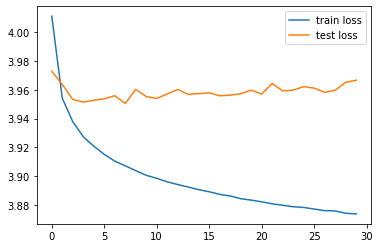

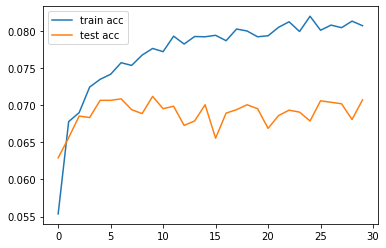

In [84]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()
plt.show()